# Testing CNN With Different Test Set
Okay, so I've downloaded all the test images from post \#13 and I've saved them onto S3. Let's take a look at all of them

## Download Test Set From S3

In [1]:
# Install tflearn
import os
os.system("sudo pip install tflearn tqdm boto3 opencv-python")

0

In [2]:
import cv2
import numpy as np
import pandas as pd
import urllib
import boto3
import math
import os
import copy
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Connect to s3 bucket
s3 = boto3.resource('s3', region_name = 'ca-central-1')
my_bucket = s3.Bucket('2017edmfasatb')

In [4]:
# Get all files in the project directory under chi_lars_face_detection/photos/
test_photos = [i.key for i in my_bucket.objects.all() if 'chi_lars_face_detection/images/test_set/' in i.key]

# Pop off first element because it's just the root directory
test_photos = test_photos[1:]

In [5]:
# Define function to convert URL to numpy array
def url_to_image(url):
    # Download the image, convert it to a numpy array, and then read it into OpenCV format
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)

    # Return the image
    return image

In [6]:
# Loop through all files to download into a single array from AWS
url_prefix = 'https://s3.ca-central-1.amazonaws.com/2017edmfasatb'

In [7]:
# Trying out the new tqdm library for progress bar
test_photos_list = [url_to_image(os.path.join(url_prefix, x)) for x in tqdm(test_photos)]

100%|██████████| 24/24 [00:03<00:00,  6.52it/s]


In [8]:
# Convert to numpy arrays
test_photos_np = np.array(test_photos_list)

In [9]:
# View shape of numpy array
test_photos_np.shape

(24, 354, 353)

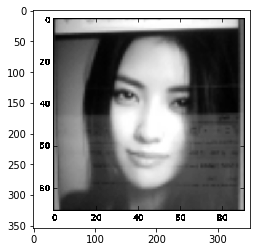

In [10]:
# Show test image in matplotlib
plt.imshow(test_photos_np[0], cmap='gray')

Hmm, actually, I forgot that I took these screenshots directly from the matplotlib output of post \#13... Here's the image I got when I googled "asian woman". I'll need to rewrite my **url_to_image** function to ensure I crop the right portions of the image.

The x coordinates look like they should be from roughly 40 to 345 pixels, and y coordinates look like they should be from 10 pixels to 335 pixels or something like that.

I've also forgotten to resize the image... so let's do that as well.

## Crop And Download S3 Again

In [11]:
# Define function to convert URL to numpy array
def url_to_image(url):
    # Download the image, convert it to a numpy array, and then read it into OpenCV format
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    
    # Crop
    image = image[20:320, 40:335]
    
    # Build resize into function
    image = cv2.resize(image, (91, 91))

    # Return the image
    return image

I iteratively found the right crop values to use so they're not quite what I had said before.

In [12]:
# Trying out the new tqdm library for progress bar
test_photos_list = [url_to_image(os.path.join(url_prefix, x)) for x in tqdm(test_photos)]

100%|██████████| 24/24 [00:03<00:00,  7.25it/s]


In [13]:
# Convert to numpy arrays
test_photos_np = np.array(test_photos_list)

In [14]:
# View shape of numpy array
test_photos_np.shape

(24, 91, 91)

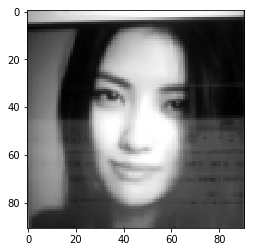

In [15]:
# Show test image in matplotlib
plt.imshow(test_photos_np[0], cmap='gray')

Let's see all of them.

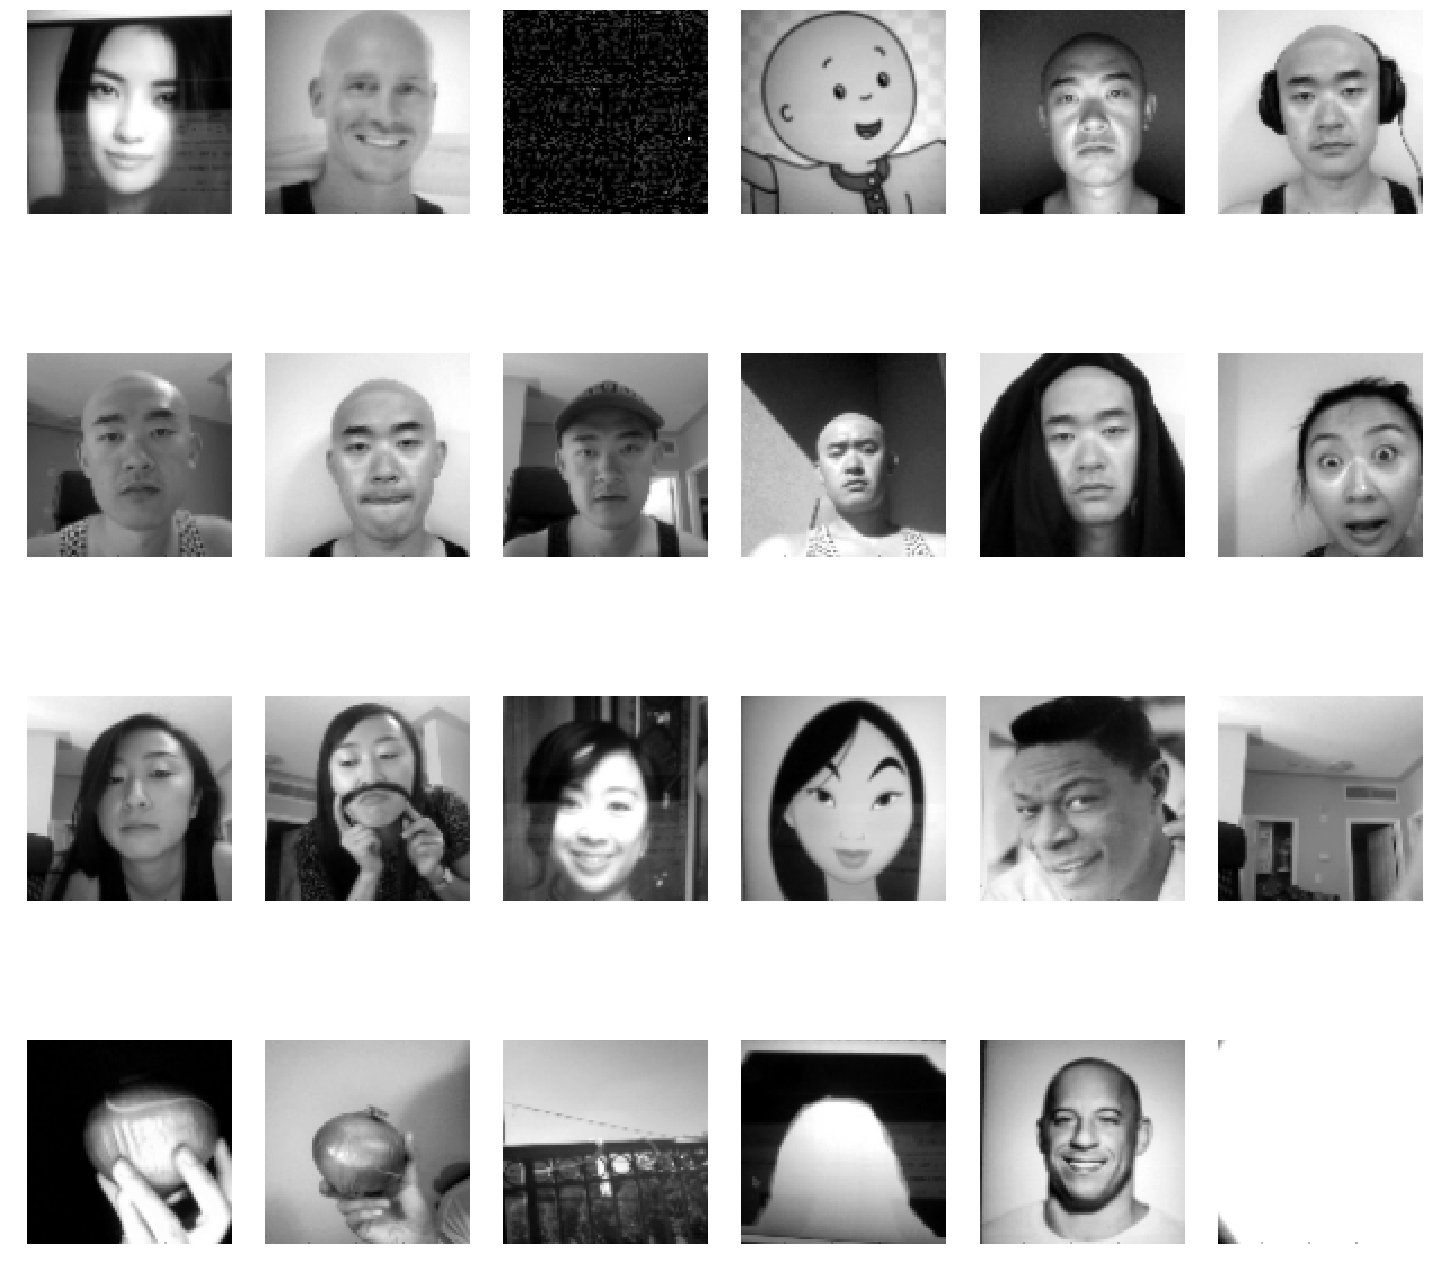

In [16]:
# Iterate and show of image resize and picture quality
images_to_plot = 24
n_cols = 6

fig, ax = plt.subplots(nrows = int(math.ceil(images_to_plot / n_cols)), ncols = n_cols, figsize = (20, 20))

i = 0
for row in ax:
    for col in row:
        col.imshow(test_photos_np[i], cmap='gray')
        col.set_axis_off()
        
        i += 1

plt.tight_layout()
plt.show()

Looks about right to me!

## Feature Building
We've loaded our alternate test set from S3, but we still need to import our original train and test sets so we can re-train our models.

In [17]:
# Temporarily load from np arrays
chi_photos_np = np.load('chi_photos_np_0.03_compress.npy')
lars_photos_np = np.load('lars_photos_np_0.03_compress.npy')

In [18]:
# View shape of numpy array
chi_photos_np.shape

(203, 91, 91)

In [19]:
# Set width var
width = chi_photos_np.shape[-1]
width

91

## Scaling Inputs

In [20]:
# Try out scaler on a manually set data (min of 0, max of 255)
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Set test data list to train on (min of 0, max of 255)
test_list = np.array([0, 255]).reshape(-1, 1)
test_list

array([[  0],
       [255]])

In [22]:
# Initialize scaler
scaler = MinMaxScaler()

In [23]:
# Fit test list
scaler.fit(test_list)

/usr/lib64/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

## Reshaping 3D Array To 4D Array

In [24]:
chi_photos_np = chi_photos_np.reshape(-1, width, width, 1)

# Keep a copy of the shaped, but unscaled data so we can view them later on as an image still
test_photos_np_orig = copy.deepcopy(test_photos_np)
test_photos_np = test_photos_np.reshape(-1, width, width, 1)

## Putting It All Together

In [25]:
# Reshape to prepare for scaler
chi_photos_np_flat = chi_photos_np.reshape(1, -1)
print(chi_photos_np_flat[:10])

test_photos_np_flat = test_photos_np.reshape(1, -1)
print(test_photos_np_flat[:10])

[[135 139 139 ..., 210 142 136]]
[[161 166 172 ..., 255 255 255]]


In [26]:
# Scale
chi_photos_np_scaled = scaler.transform(chi_photos_np_flat)
print(chi_photos_np_scaled[:10])

test_photos_np_scaled = scaler.transform(test_photos_np_flat)
print(test_photos_np_scaled[:10])

[[ 0.52941176  0.54509804  0.54509804 ...,  0.82352941  0.55686275
   0.53333333]]
[[ 0.63137255  0.65098039  0.6745098  ...,  1.          1.          1.        ]]


In [27]:
# Reshape to prepare for scaler
lars_photos_np_flat = lars_photos_np.reshape(1, -1)
lars_photos_np_scaled = scaler.transform(lars_photos_np_flat)

In [28]:
# Reshape
chi_photos_reshaped = chi_photos_np_scaled.reshape(-1, width, width, 1)
lars_photos_reshaped = lars_photos_np_scaled.reshape(-1, width, width, 1)
test_photos_reshaped = test_photos_np_scaled.reshape(-1, width, width, 1)

print('{} has shape: {}'. format('chi_photos_reshaped', chi_photos_reshaped.shape))
print('{} has shape: {}'. format('lars_photos_reshaped', lars_photos_reshaped.shape))
print('{} has shape: {}'. format('test_photos_reshaped', test_photos_reshaped.shape))

chi_photos_reshaped has shape: (203, 91, 91, 1)
lars_photos_reshaped has shape: (200, 91, 91, 1)
test_photos_reshaped has shape: (24, 91, 91, 1)


In [29]:
# Create copy of chi's photos to start populating x_input
x_input = copy.deepcopy(chi_photos_reshaped)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (203, 91, 91, 1)


In [30]:
# Concatentate lars' photos to existing x_input
x_input = np.append(x_input, lars_photos_reshaped, axis = 0)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (403, 91, 91, 1)


## Preparing Labels

In [31]:
# Create label arrays
y_chi = np.array([[1, 0] for i in chi_photos_reshaped])
y_lars = np.array([[0, 1] for i in lars_photos_reshaped])

print('{} has shape: {}'. format('y_chi', y_chi.shape))
print('{} has shape: {}'. format('y_lars', y_lars.shape))

y_chi has shape: (203, 2)
y_lars has shape: (200, 2)


In [32]:
# Preview the first few elements
y_chi[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [33]:
y_lars[:5]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [34]:
# Create copy of chi's labels to start populating y_input
y_input = copy.deepcopy(y_chi)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (203, 2)


In [35]:
# Concatentate lars' labels to existing y_input
y_input = np.append(y_input, y_lars, axis = 0)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (403, 2)


## CNN \#1 - Less Convolutional Filters

In [42]:
# TFlearn libraries
import tflearn
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

### Train Test Split

In [37]:
# Import library
from sklearn.model_selection import train_test_split

In [38]:
print(x_input.shape)
print(y_input.shape)

(403, 91, 91, 1)
(403, 2)


In [39]:
# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, test_size = 0.1, stratify = y_input)

x_train = np.array(x_train, dtype = np.float64)
x_test = np.array(x_test, dtype = np.float64)
y_train = np.array(y_train, dtype = np.float64)
y_test = np.array(y_test, dtype = np.float64)

### Training & Predict

Let's first create a standardized function to output the predicted results with labels to save ourselves some code.

In [40]:
# Create function to output prediction matrix
def prediction_matrix(y, y_pred, y_pred_proba, images_to_plot, n_cols):
    fig, ax = plt.subplots(nrows = int(math.ceil(images_to_plot / n_cols)), ncols = n_cols, figsize = (20, 20))
    
    i = 0
    for row in ax:
        for col in row:
            col.set_title('Prediction: {} ({})'.format(
                y_pred[i], 
                "{0:.0f}%".format(y_pred_proba[i][0] * 100) if y_pred[i] == 'chi' else "{0:.0f}%".format(y_pred_proba[i][1] * 100)
            ))
            col.imshow(y[i], cmap='gray')
            col.set_axis_off()

            i += 1

    plt.tight_layout()
    plt.show()

Training Step: 59  | total loss: 0.09341 | time: 0.105s
| SGD | epoch: 010 | loss: 0.09341 - acc: 0.9851 -- iter: 320/362
Training Step: 60  | total loss: 0.08953 | time: 1.131s
| SGD | epoch: 010 | loss: 0.08953 - acc: 0.9871 | val_loss: 0.01422 - val_acc: 1.0000 -- iter: 362/362
--


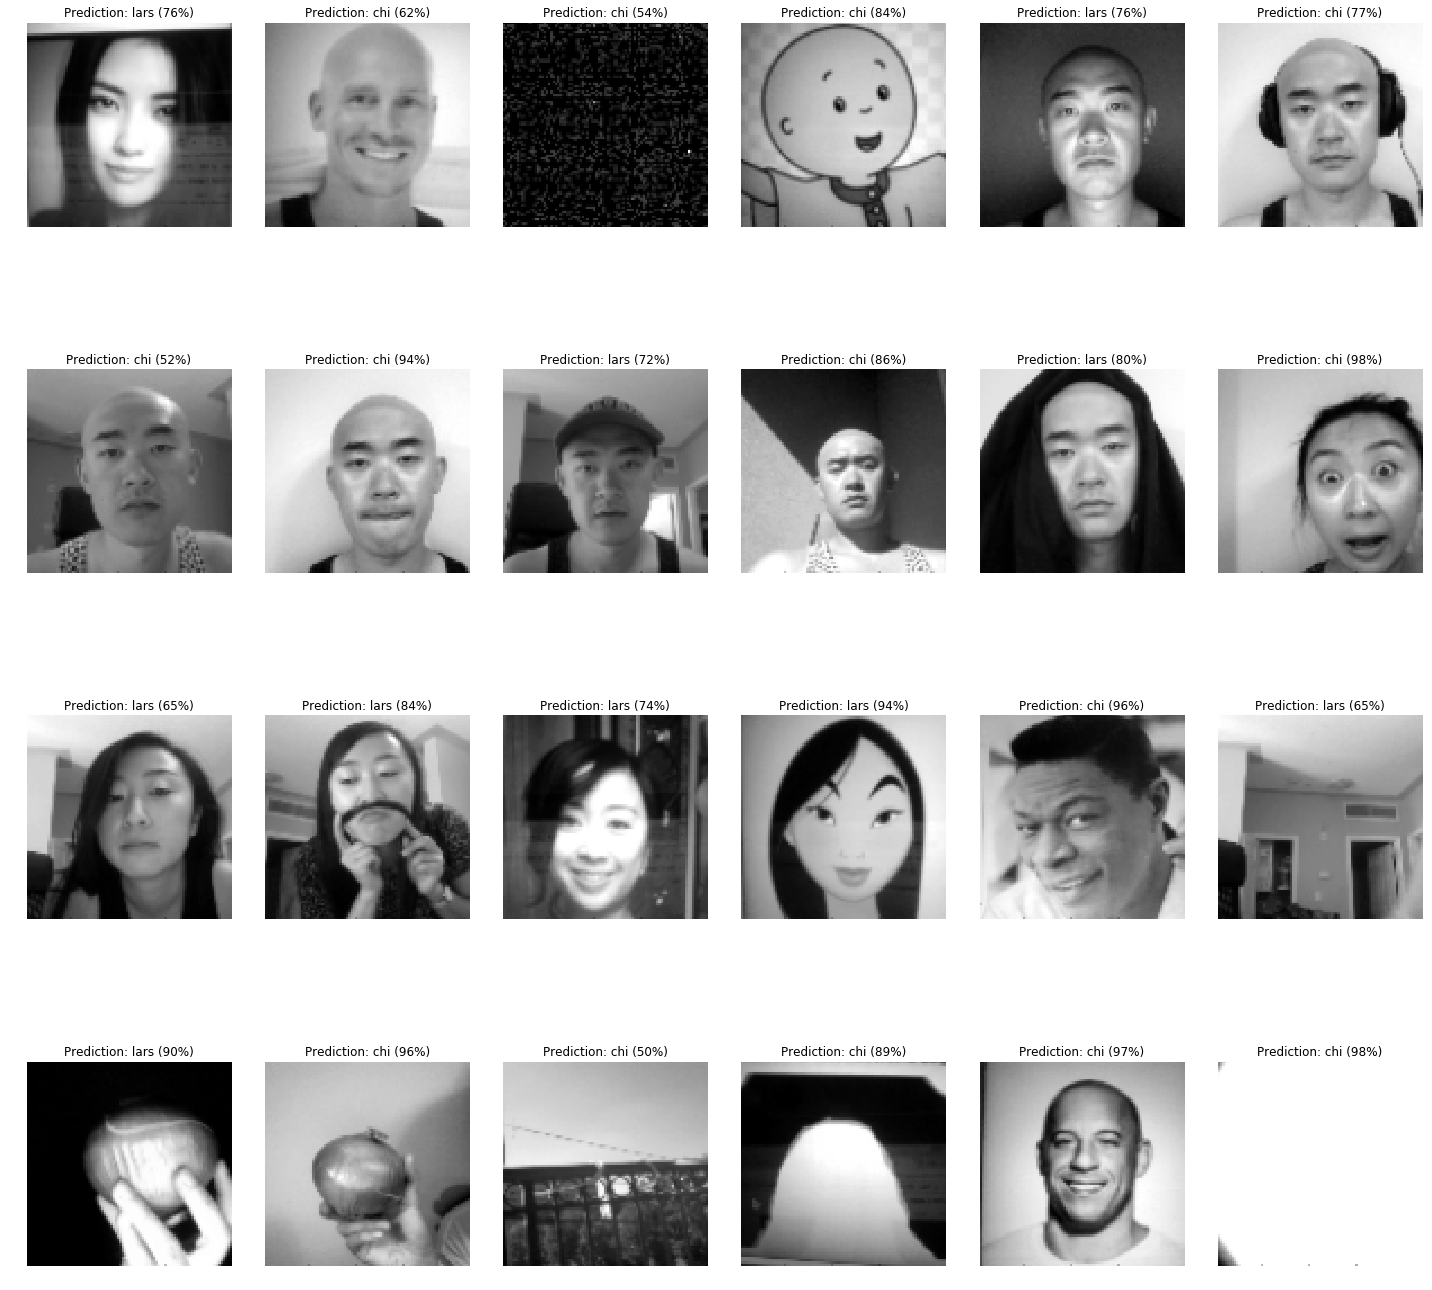

In [83]:
import tensorflow as tf

with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
    
    # Train with data
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 10,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])

    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

Okay, let's review what we have here. For the most part, we're seeing similar results that we got when we used 32 / 64 filters vs 3 / 3. One difference I can spot right away is that the model is not as sure as it used to be. In the last model, I was pretty much always getting 99% confidence whatever the vote was. Here, while the predictions are very similar, rarely do we ever see a 99% vote of confidence (or even above 90%).

Other observations with the predictions themselves in no particular order:
- Again, it thinks the completely black photo is me (albeit only with 54% confidence, which is maybe what we'd expect)
- It thinks the all white photo is me as well (interestingly enough, with _**MUCH**_ more confidence)
- It thinks the silhouette I drew is me (with 89% confidence!)
- It still thinks Nat King Cole is me (with pretty high confidence at 96%!)
- It still thinks me with a hat is Lars (76% confidence)

The silhouette one is the one that gets me, because I drew that literally to match what I thought it would predict as Larissa. Clearly, the hair and shading isn't the only thing this particular NN is looking for.

I also noticed that the random states (initiated by the starting filters and weights) _**really**_ impact the predictions. I ran the NN above a few times while debugging, and I was getting a variety of answers for each estimate. Let's run it again and see what we get.

#### Prediction Round 2

Training Step: 59  | total loss: 0.63224 | time: 0.115s
| SGD | epoch: 010 | loss: 0.63224 - acc: 0.8279 -- iter: 320/362
Training Step: 60  | total loss: 0.63119 | time: 1.143s
| SGD | epoch: 010 | loss: 0.63119 - acc: 0.8362 | val_loss: 0.59753 - val_acc: 0.6585 -- iter: 362/362
--


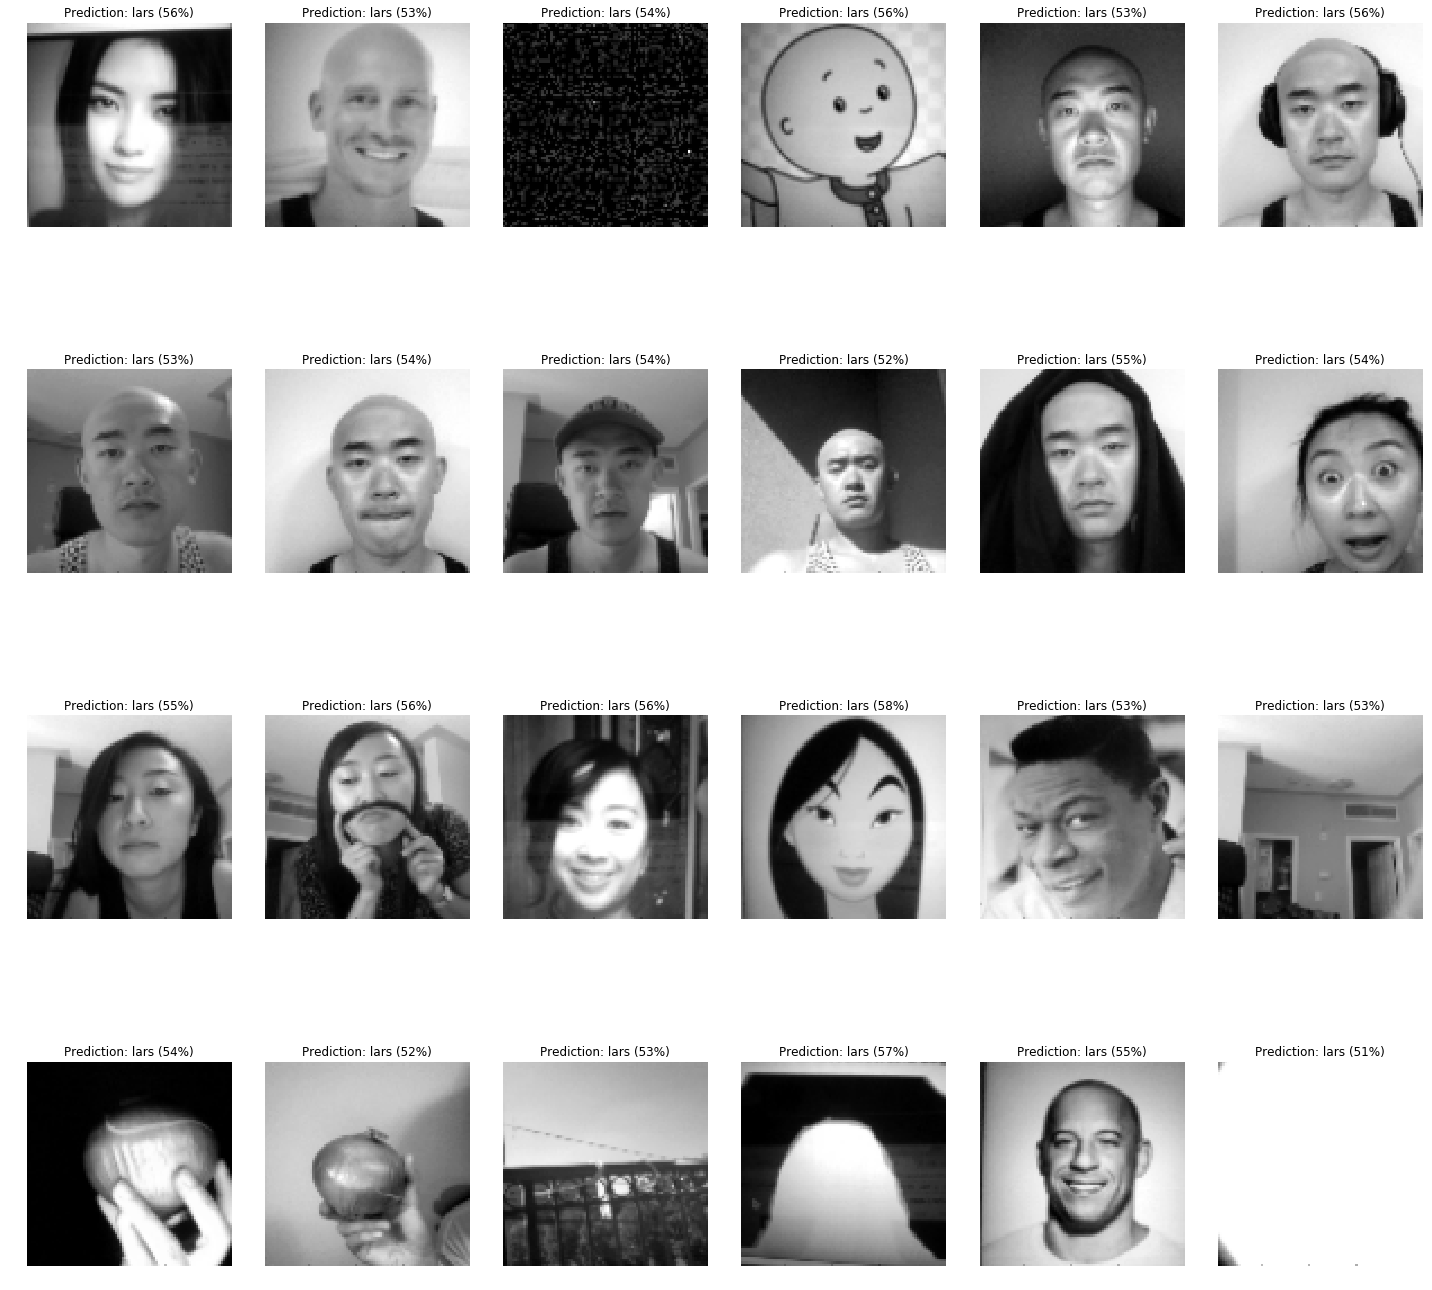

In [82]:
import tensorflow as tf

with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
    
    # Train with data
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 10,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])

    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

It actually thinks everything is Lars! We could probably tweak this a bit by playing around with the ROC cutoff point... it seems that the model still does okay if we set the cutoff to guess
- Lars if probability of Lars >= 55%
- Chi if probability of Lars < 55%

And, even then, we still get a few hiccups as it would be classifying Caillou and Vin Diesel as Lars, but that's to be expected. I'm not sure if this is a matter of the filters or learning rate or maybe even the amount of fully connected nodes even. Maybe what I'd need to do as well is to ensemble multiple NN's together to make a final prediction, but let's check out the NN's to come before diving down that rabbit hole.

## CNN \#2 - Smaller Filter Sizes

Training Step: 35  | total loss: 0.47202 | time: 0.105s
| SGD | epoch: 006 | loss: 0.47202 - acc: 0.9967 -- iter: 320/362
Training Step: 36  | total loss: 0.46283 | time: 1.131s
| SGD | epoch: 006 | loss: 0.46283 - acc: 0.9973 | val_loss: 0.38509 - val_acc: 1.0000 -- iter: 362/362
--


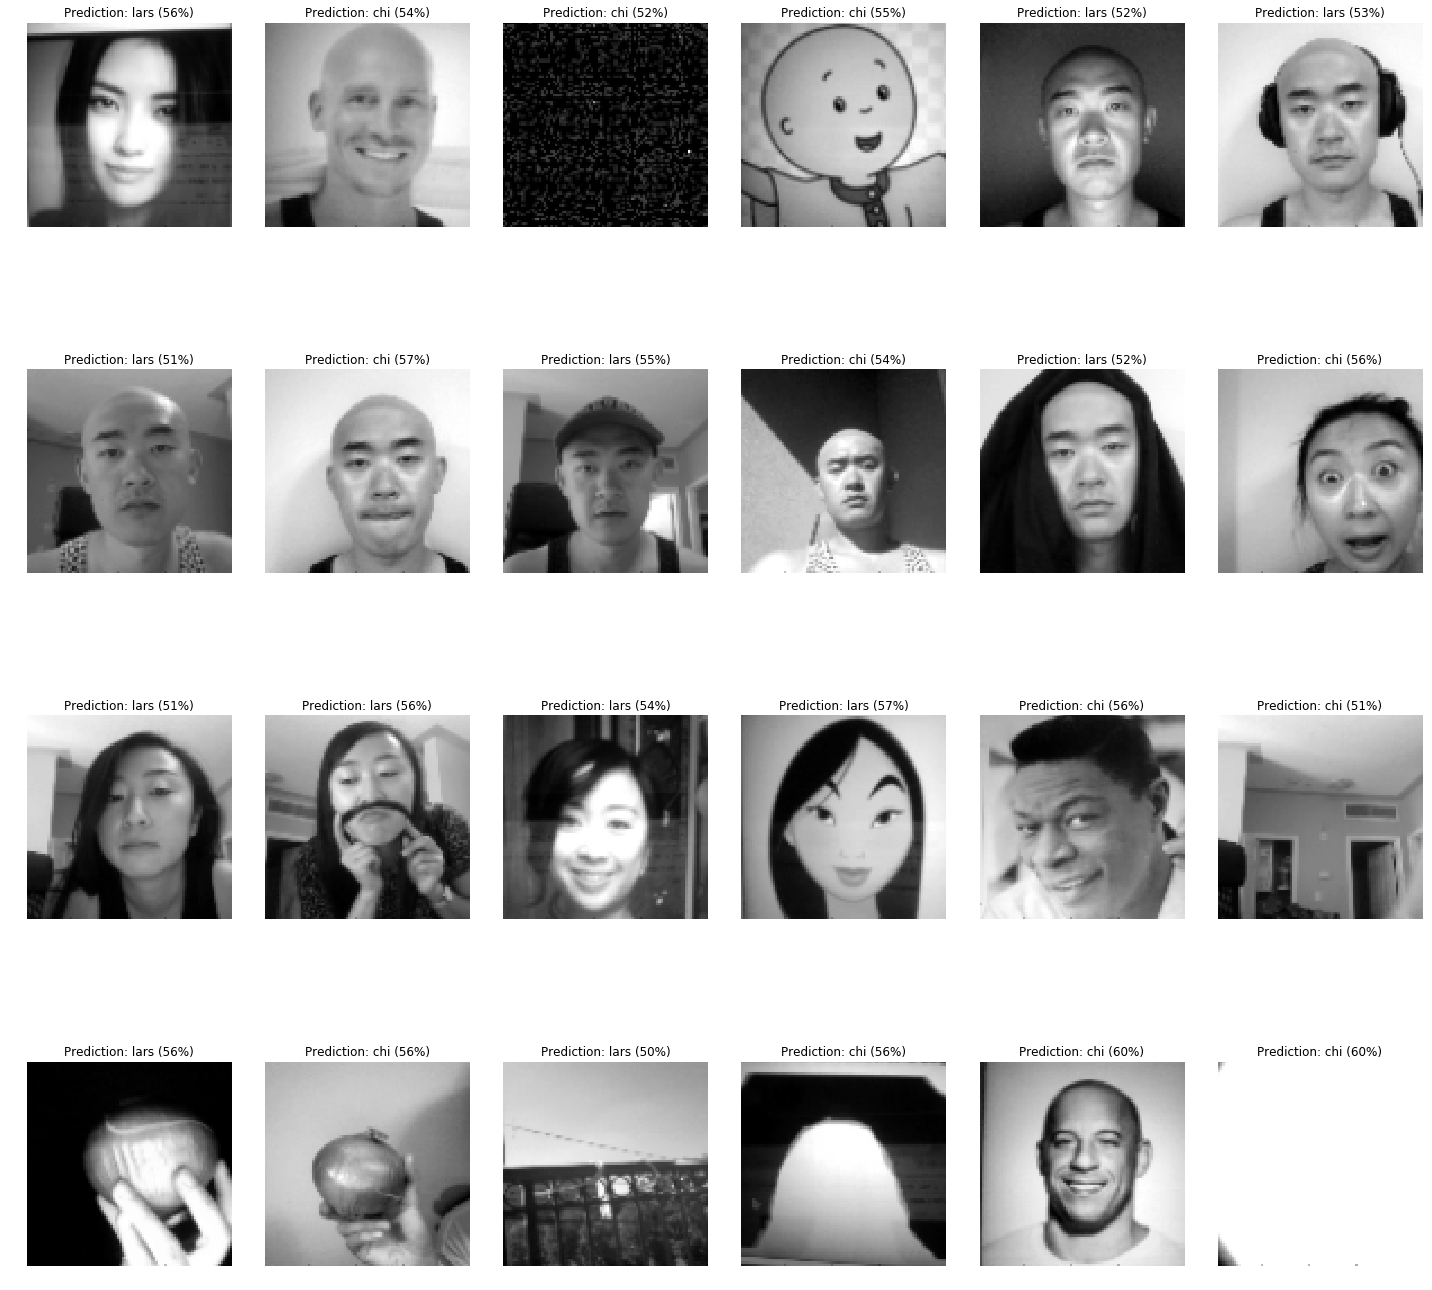

In [84]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 3, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 3, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 6,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])

    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

Even with 3 filters of size 3, this thing does pretty well! It's generally able to capture the photos and it's making the same mistakes that I'd expect it to make. The confidences here are _**much**_ lower, generally hovering in the 50-60% range. I ran this one a few times too and the guesses seem to stay within that range. I also ran this one at only 6 epochs (which was where I found it converged to 100%), so maybe that also plays a contributing factor as well. Let's move on.

## CNN \#3 - Larger Filter Sizes

Training Step: 35  | total loss: 0.01770 | time: 0.272s
| SGD | epoch: 006 | loss: 0.01770 - acc: 0.9992 -- iter: 320/362
Training Step: 36  | total loss: 0.01525 | time: 1.338s
| SGD | epoch: 006 | loss: 0.01525 - acc: 0.9993 | val_loss: 0.00440 - val_acc: 1.0000 -- iter: 362/362
--


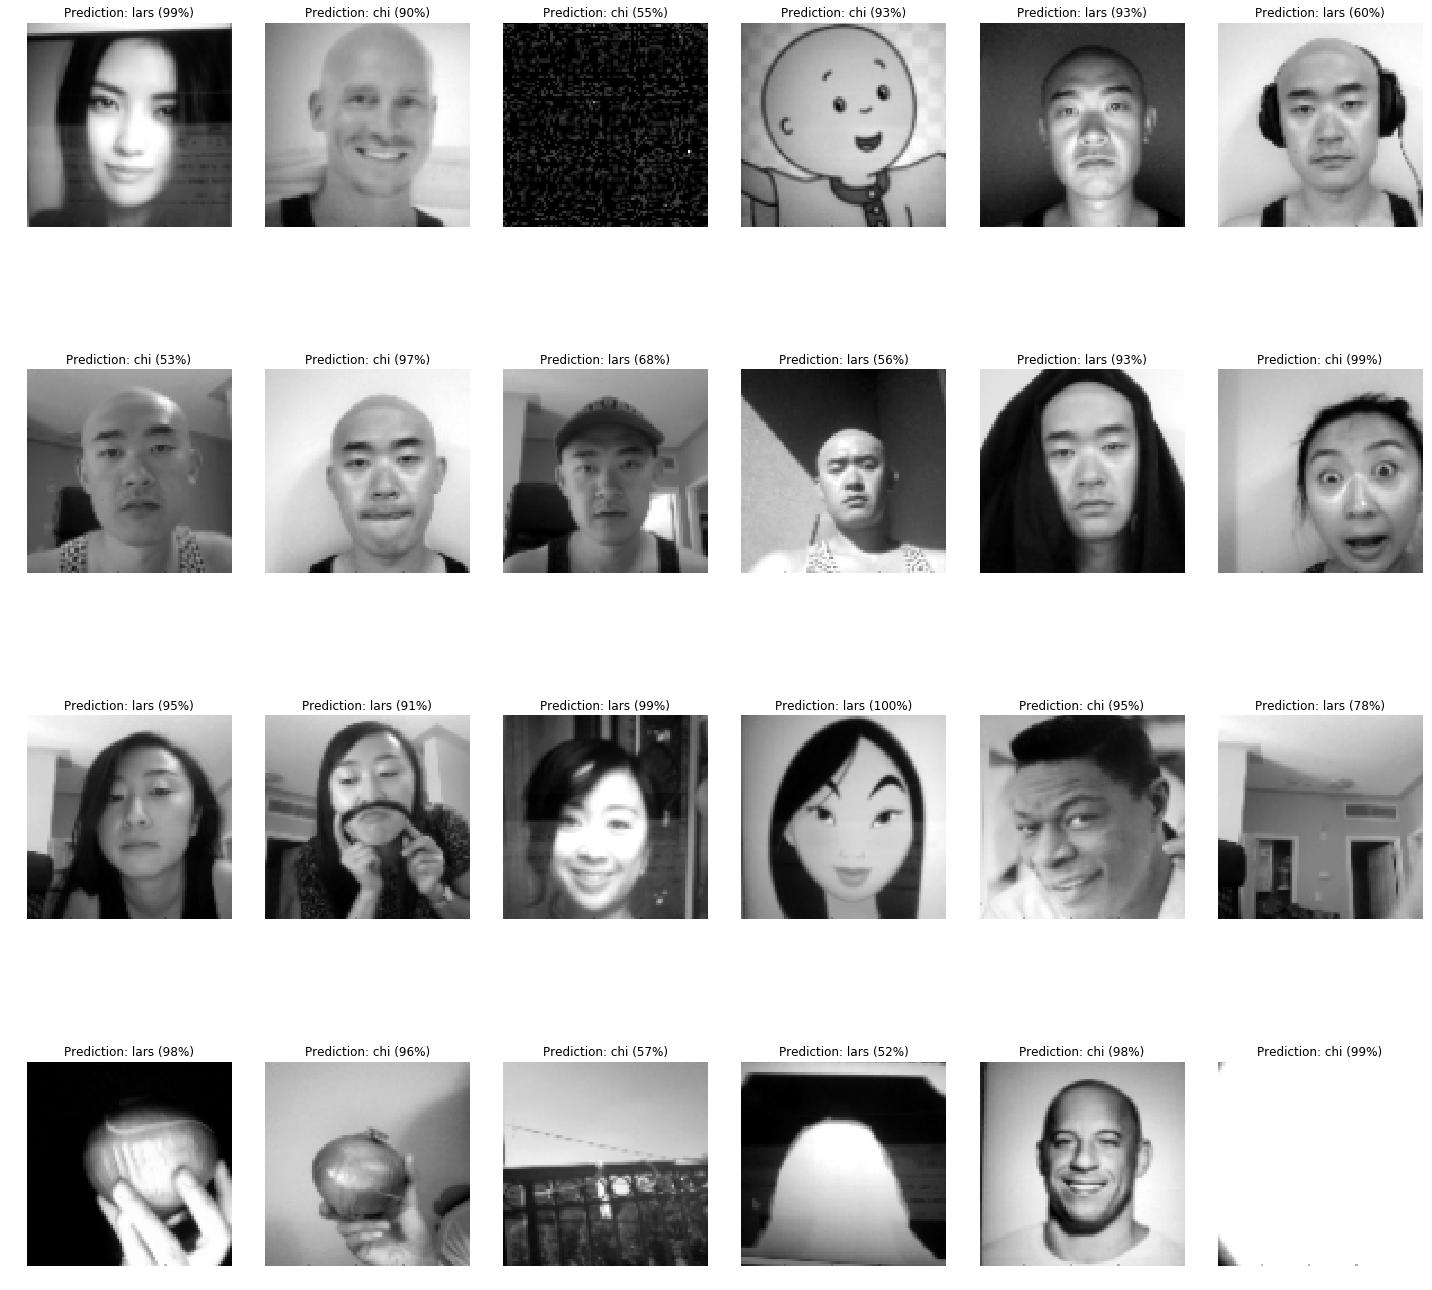

In [43]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 6,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])
    
    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

Some pretty interesting confidences here... I see my first 100% and it's... _**Mulan as Larissa**_. That's decently fitting, that's why I chose Mulan in the first place! Following that, is the image result of the google search "Asian Girl", again which is fitting because that's why I googled that. These two (especially the Mulan one) actually resemble the training images quite well - similar hair style and brighter background with little noise.

This is also reflected in the 98% confidence _**Vin Diesel**_ prediction. In fact, Vin Diesel got a higher score than _**my own photo that I took in the same location as the training photo!!**_. Even the onion with the white wall got a prediction confidence close to my own photo...

We see in these past few CNNs that the purposely confusing photos have much less confidence as well:
- Black image (55%)
- Headphones (60%)
- Patio view (57%)
- Empty living room (78%)

It seems that the larger filters may also be helping tell _**what even has the shape of a human**_.

## CNN \#4 - More Convolutional Layers

Training Step: 59  | total loss: 0.24002 | time: 0.475s
| SGD | epoch: 010 | loss: 0.24002 - acc: 0.9882 -- iter: 320/362
Training Step: 60  | total loss: 0.21013 | time: 1.586s
| SGD | epoch: 010 | loss: 0.21013 - acc: 0.9897 | val_loss: 0.00803 - val_acc: 1.0000 -- iter: 362/362
--


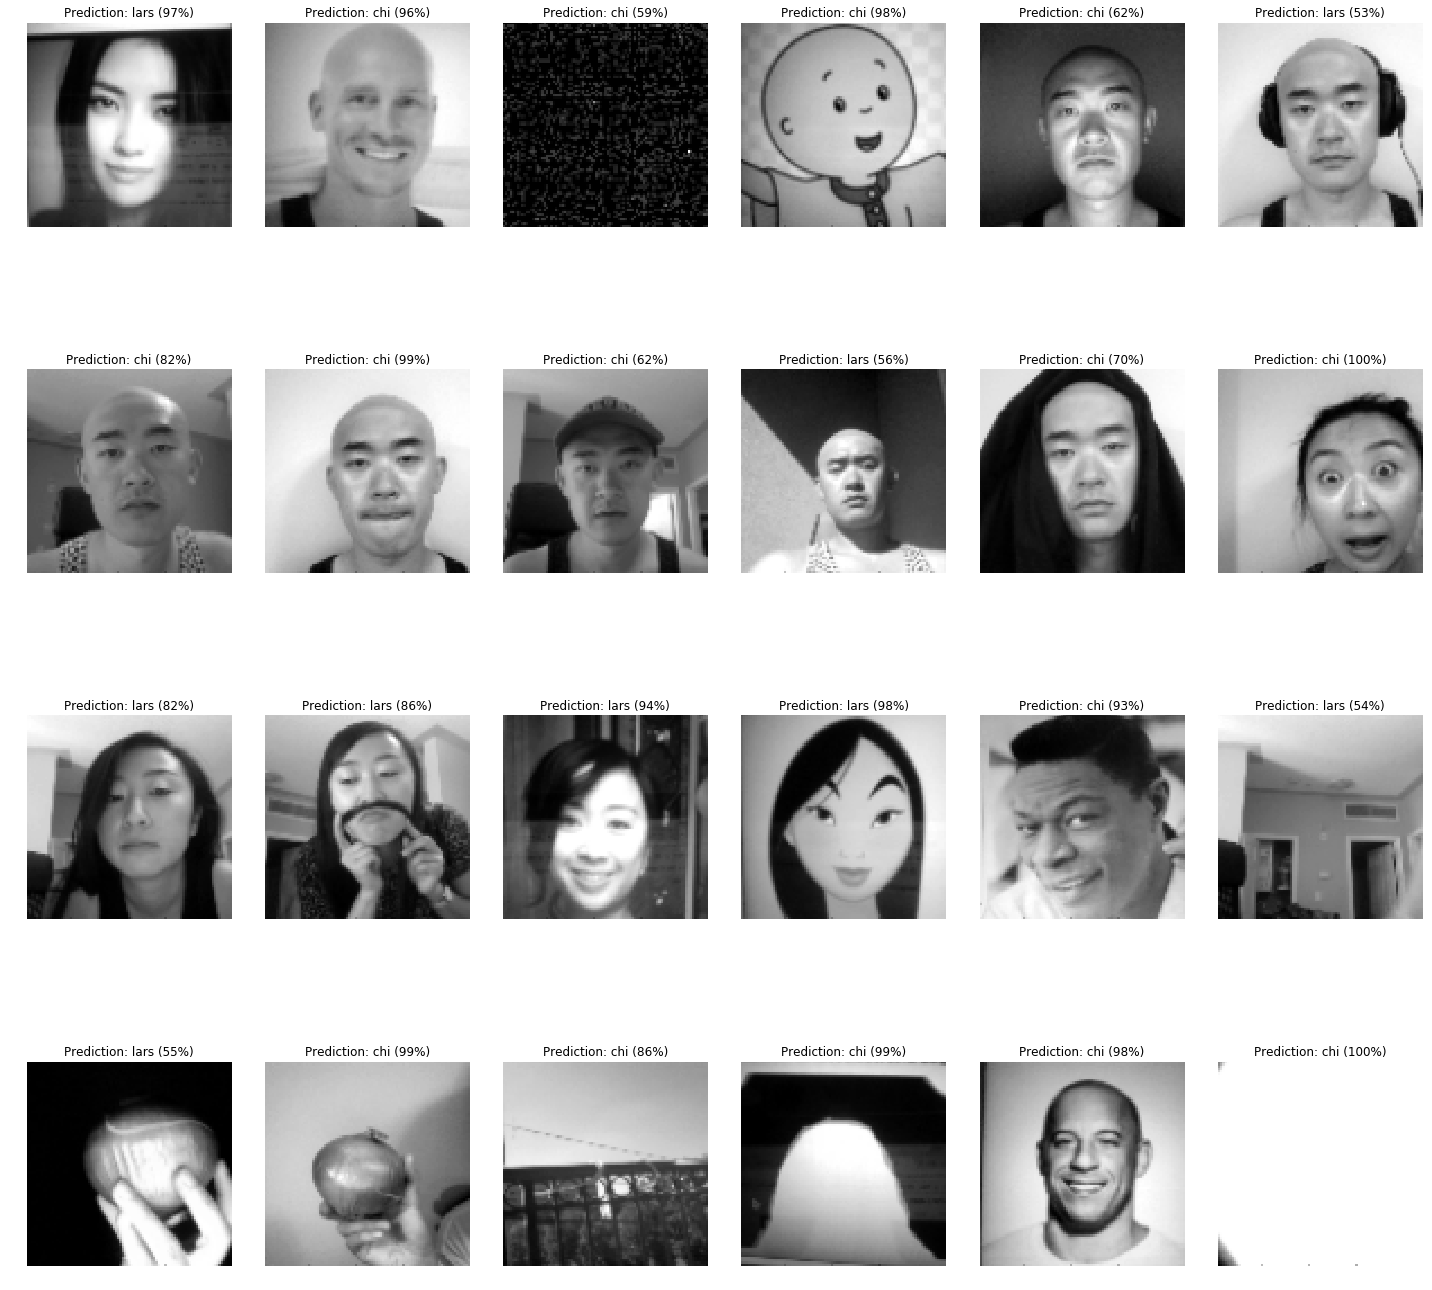

In [49]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')
    
    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_3')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_3')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 10,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])
    
    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

Slight variations, but no amazing breakthroughs from the last CNN.

## CNN \#5 - More Epochs

Training Step: 599  | total loss: 0.09609 | time: 0.146s
| SGD | epoch: 100 | loss: 0.09609 - acc: 0.9803 -- iter: 320/362
Training Step: 600  | total loss: 0.08765 | time: 1.179s
| SGD | epoch: 100 | loss: 0.08765 - acc: 0.9823 | val_loss: 0.01014 - val_acc: 1.0000 -- iter: 362/362
--


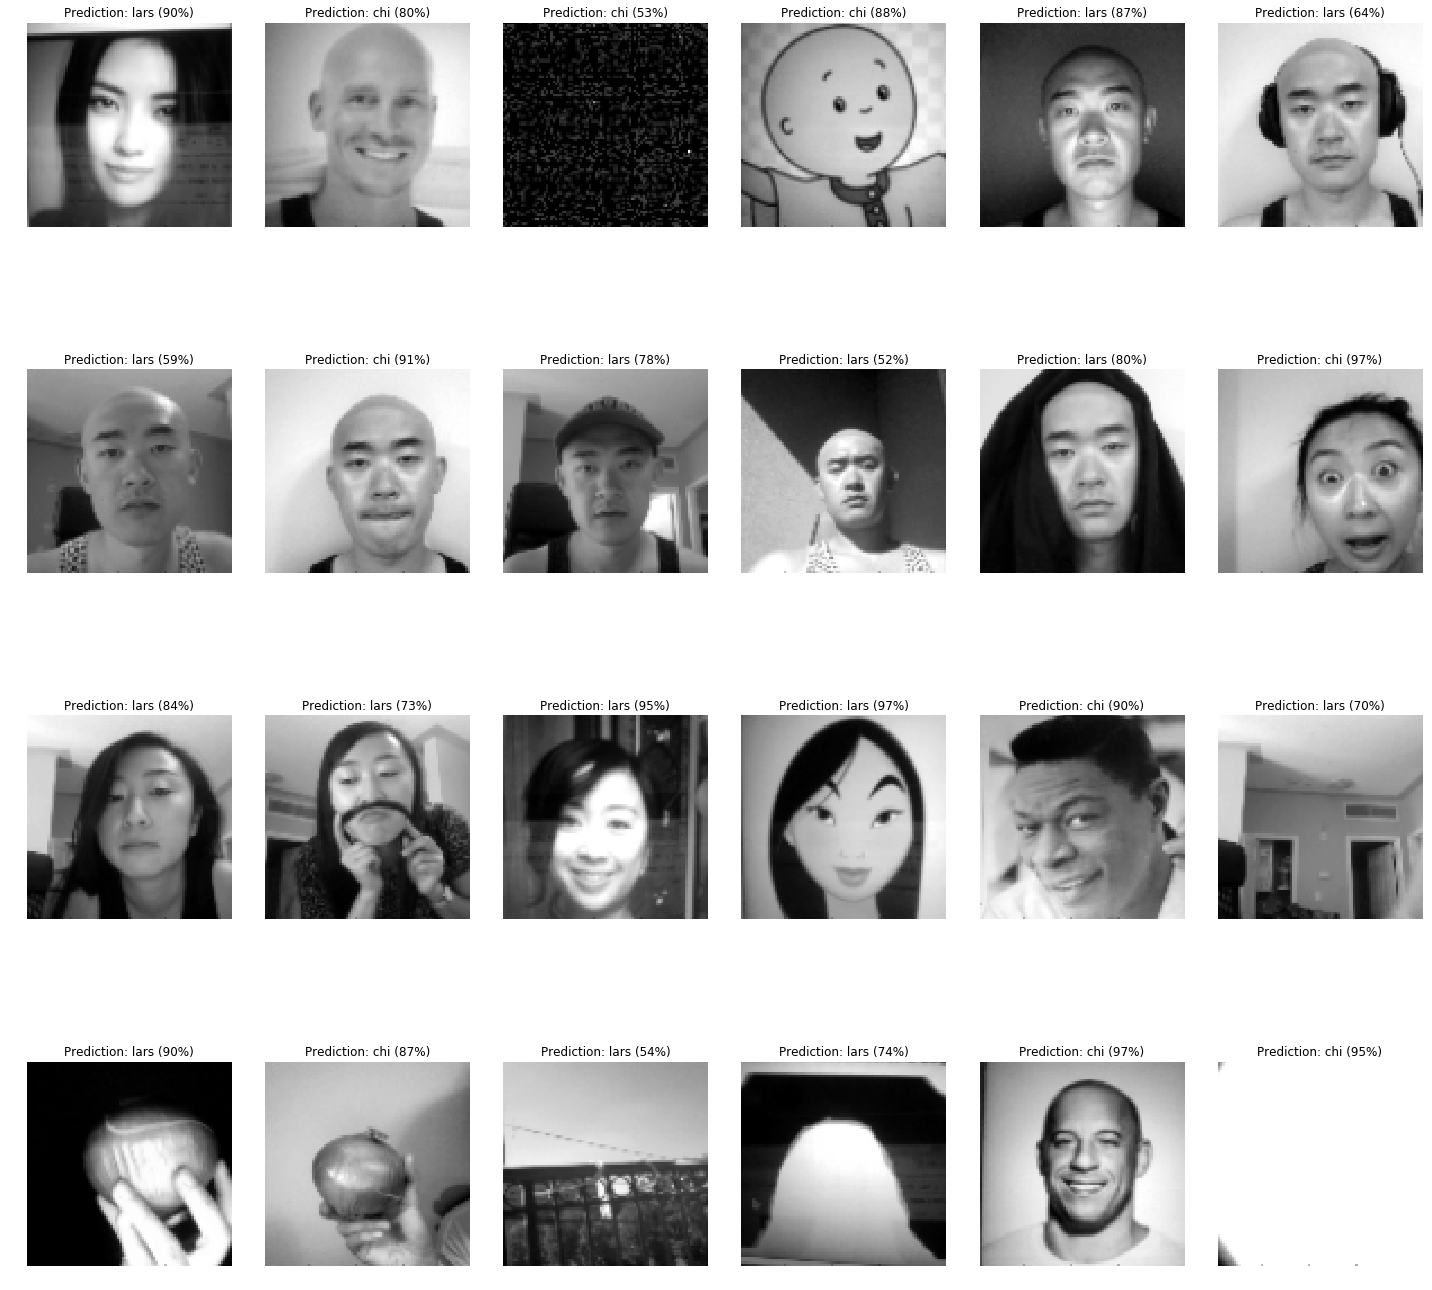

In [50]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.001, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 100,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])
    
    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

I'm definitely starting to see a pattern of which photos the model continuously guesses me or Lars.

It really thinks Vin Diesel, Caillou, Nat King Cole, and Lars with her hair tied back are me. It REALLY thinks Mulan is Lars, as well as "Asian Girl" and the photo of Lars to the left of Mulan.

I'm actually now starting to think it's the area of the left side of the forehead is that area that has a large impact... regardless, we're still working with 91 by 91 filters so the entire shape of the image should take effect.

Another thing I'm noticing is that the 100 epoch models have a lot less variance than the 10 epoch models. Let's train this again:

Training Step: 599  | total loss: 0.06408 | time: 0.142s
| SGD | epoch: 100 | loss: 0.06408 - acc: 0.9889 -- iter: 320/362
Training Step: 600  | total loss: 0.05906 | time: 1.175s
| SGD | epoch: 100 | loss: 0.05906 - acc: 0.9900 | val_loss: 0.01134 - val_acc: 1.0000 -- iter: 362/362
--


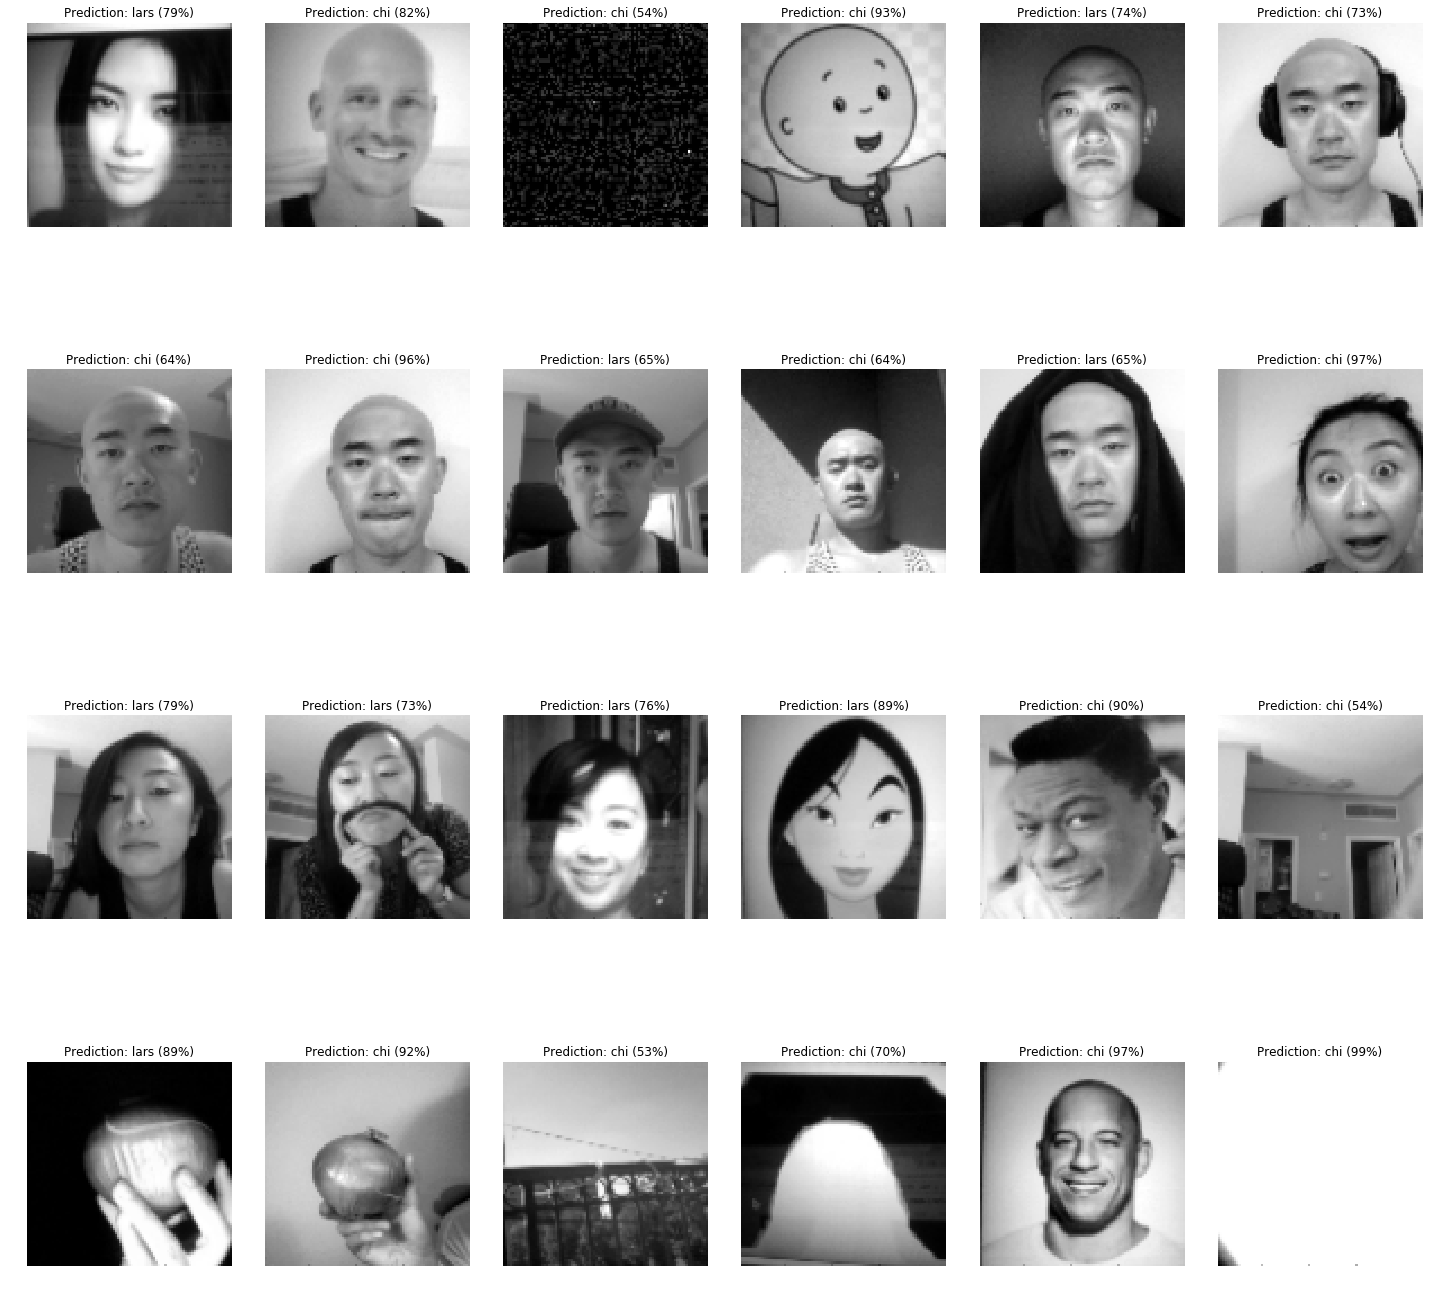

In [52]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.001, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 100,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])
    
    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

We're seeing very similar confidence values across multiple trained models. The random initiation of the weights are converging more and more towards some type of optima here. With each time we train this model, we are a bit more confident that the error of each model will be similar to each other, and it won't guess "Lars" every single time with confidence values of 50-60%.

## CNN \#6 - More Filters, Smaller Filter Size

Training Step: 599  | total loss: 0.03279 | time: 0.149s
| SGD | epoch: 100 | loss: 0.03279 - acc: 0.9958 -- iter: 320/362
Training Step: 600  | total loss: 0.03081 | time: 1.183s
| SGD | epoch: 100 | loss: 0.03081 - acc: 0.9962 | val_loss: 0.01213 - val_acc: 1.0000 -- iter: 362/362
--


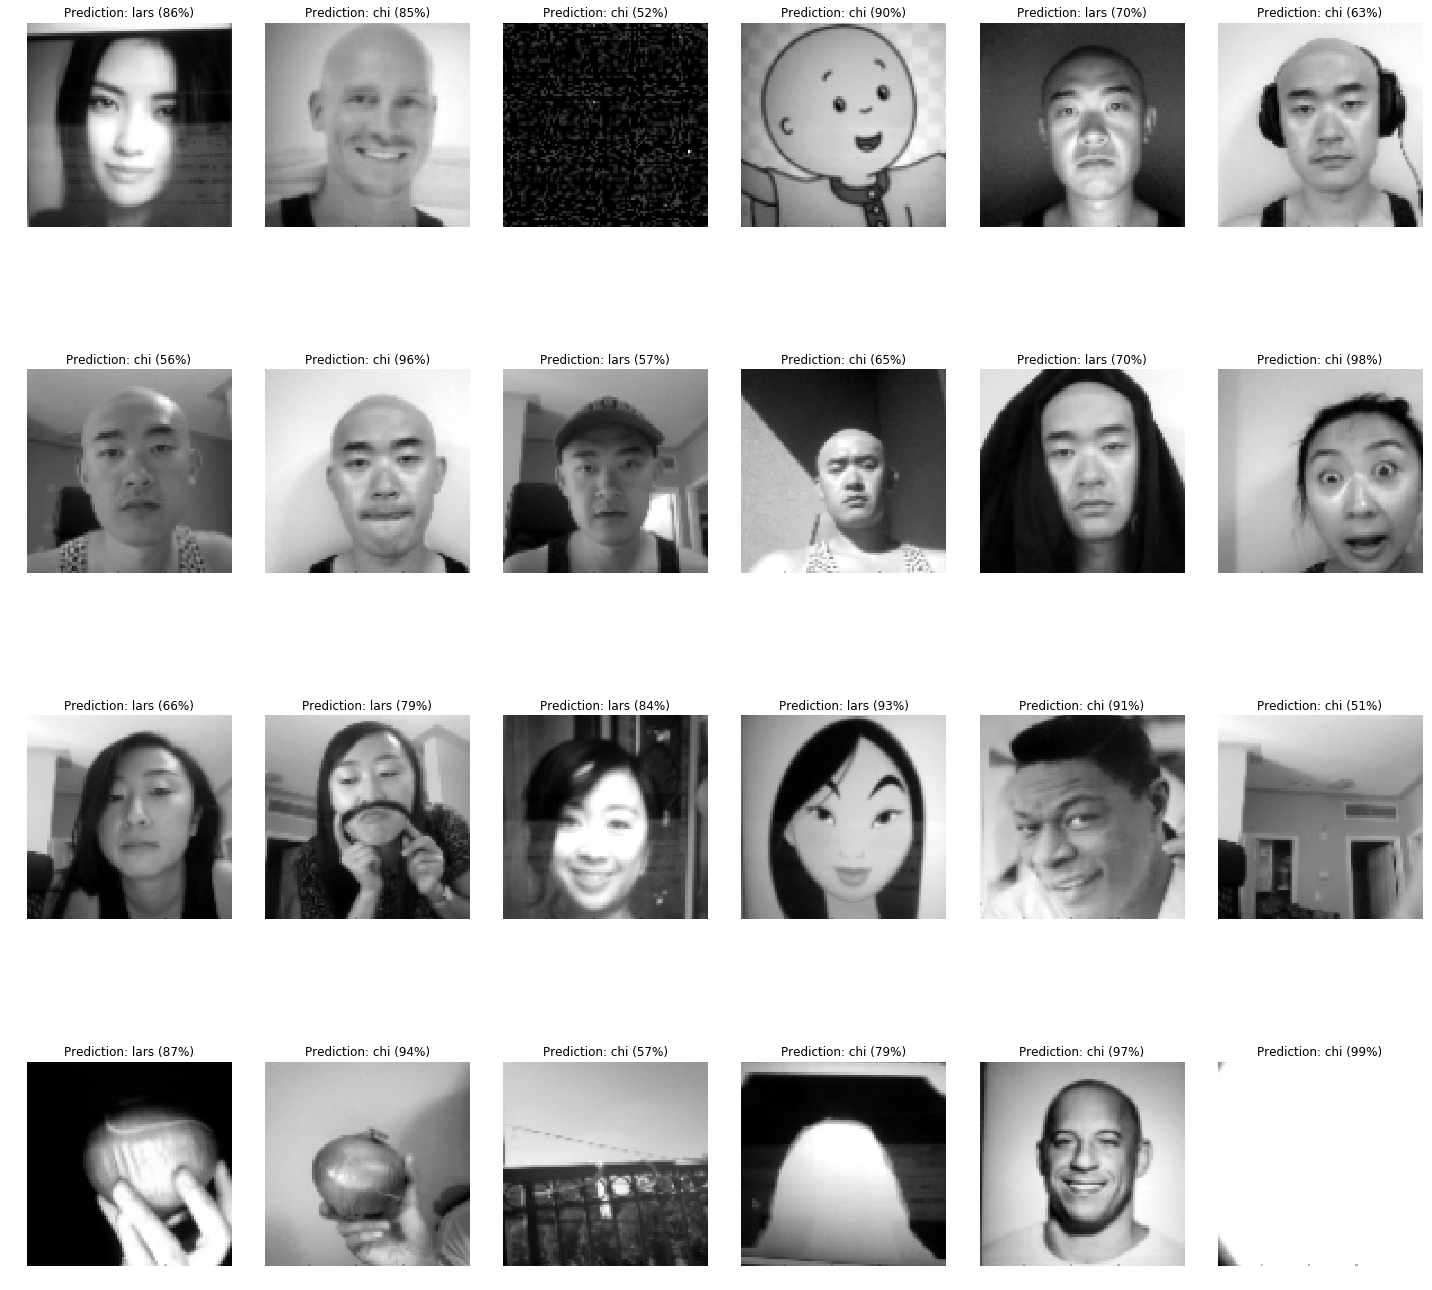

In [53]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 9, 30, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.001, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 100,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Predict on test set
    y_alt_pred_proba = np.array(model.predict(test_photos_reshaped))
    y_alt_pred = np.array(['chi' if y[0] > 0.5 else 'lars' for y in y_alt_pred_proba])
    
    # Show prediction matrix
    prediction_matrix(test_photos_np_orig, y_alt_pred, y_alt_pred_proba, images_to_plot, n_cols)

Alright then. The predictions are actually still quite similar to our last model with a large 91 x 91 filters. It seems we've converged on set ranges for confidence levels for each of our test images. Overall, I'd say it's doing pretty well - It looks like, out of all of the parameters we tried tweaking, the number of epochs it took for us to train it had the most impact on the accuracy and stability of our predictions.

Remember how prediction error is explained by two different types of errors, bias and variance:

<img src="https://i.stack.imgur.com/r7QFy.png" style="width: 500px;"/>

It's hard to understand your bias if your variance is high. If your variance is high, the error you get from any single model (any one of those dots above) is because of bias or variance. If your variance is low, you can, through cross validation or other means, confirm that your variance is indeed low and attribute the remaining error to your bias.

I felt my errors were mostly explained by variance when I started this post off, and when I changed the number of epochs, I quickly saw my prediction confidences converge to a certain tight range. From that point on, not many of the parameters I tweaked made too much of a difference. I was seeing the same photos classified as me, Larissa, or inconclusive (50-60% confidence).

To get an even better sense of how each model is doing, it would be great to train each for a sample of like 100 and use the central limit theorem to my advantage to see what the average and standard deviation of prediction confidences are. This would basically give me a good sense of the variance for each model. The bias... well, in this specific case, I wasn't really trying to make any _**accurate**_ predictions. I was merely exploring the model on different test sets. For example, the patio photo - There isn't a "correct" label for this. I was just curious to see what the result _**would be**_. For those that are obviously photos of me or Lars, I can gauge the bias error very easily. For those in between, it's a bit subjective. Obviously I picked Vin Diesel to emulate my bald head, but to say that the model should have guessed Chi with 100% certainty is naive considering my current knowledge and experience with NNs. I would expect it to lean towards Chi, but should it be 70%? 80%? 90%? 100%? I'm not sure.

I think that just about wraps it up for this project for me. I've gotten a taste of CNNs and, at the end of the day, am quite amazed at how a few lines of TFlearn codes can do this. I'll close it up with one more post!